<a href="https://colab.research.google.com/github/SteffiJF/ForecastingRedWineRankings/blob/main/WineMaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code used for setting up LSTM, SARIMAX, and persistence forecasts of red wine sales numbers and ranking analysis. Features available for SARIMAX and LSTM are found under 'settings'. Only one model is evaluated at a time, you can switch between these under 'Ranking'. The two files that are loaded need to be constructed using WinePreprocessing.ipynb

# Setup

In [96]:
!pip install pmdarima
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import pmdarima as pm
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
import pandas.util.testing as tm
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from numpy import array
from numpy import hstack
from imblearn.over_sampling import RandomOverSampler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import seaborn as sns
import matplotlib._color_data as mcd
from matplotlib.lines import Line2D
import random
from scipy.stats import spearmanr

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(10, 6)})
sns.set_palette("tab10", n_colors=10, desat=0.5, color_codes=True)
color=['b','r','g','y','m']
%matplotlib inline

Settings

In [97]:
#Choose whether using 'testing' or 'full' dataset
status = 'full'

#Choose whether to run SARIMA analysis
sarima_status='run'#'run'

#Choose which files to read. Need to be the same price groups as eval_PG below
sarima_load=True
ff_file ='/content/drive/MyDrive/vindata/forward_filling_125.npy'
s_file = '/content/drive/MyDrive/vindata/sarima_forecasts_125.npy'


#Choose exogenous feature for SARIMAX, price or shifted sales of top ranked article
# 'Price' or 'Top'
#exog = 'Top'

#Choose whether to load LSTM model or construct new
LSTM_load = False
LSTM_file = '/content/drive/MyDrive/vindata/LSTM_model_new_shape.h5'


#Choose features
ohe_feature=False #If set to false it is added for sample selection then removed
price_feature=False
utvalg_feature=False
date_feature = False #Should not be used
newness_feature = False
top_feature=False

#Choose price group
train_PG=[125] #Price groups to train on
eval_PG=[125] #Price groups to evaluate model on

#Settings
n_steps = 20 #months as input
n_output = 3 #months to forecast
period = 12 #seasonal period
n_sets = 119 #len(supervised_values) 
n_test = round(n_sets*0.2)
n_train = round((n_sets-n_test)*0.8) #the last sets are left for validation
n_val = 13 #Nr of validation months

#LSTM model
n_epoch = 100
n_batch = 64
n_neurons = 64


#number of features in addition to sales data
n_features = 9 + n_steps*price_feature + 4*utvalg_feature + date_feature + newness_feature + n_steps*top_feature 

#Total width of sample before reshaping into (time,features) dimension
n_input = n_steps + n_features - 9*(1-ohe_feature) 

#number of timedependent features
t_features = 1 + price_feature + top_feature 

#nr features in LSTM input (batch,time,features)
feature_width = 1 + 9*ohe_feature + 4*utvalg_feature + price_feature + date_feature + newness_feature + top_feature 

Loading data from Google Disk, concatenating data, removing rows without ranking, adding column to identify new products (within 12 months)

In [98]:
#Loading dataframes containing two most common red wine groups
df75 = pd.read_csv('/content/drive/MyDrive/vindata/RedWines75.csv')
df9 = pd.read_csv('/content/drive/MyDrive/vindata/RedWines9.csv')

#Removing old index
df75 = df75.drop('Unnamed: 0', axis=1)
df9 = df9.drop('Unnamed: 0', axis=1)

#Setting index to yyyy-mm-dd
df75['År_Måned'] = pd.to_datetime(df75['År_Måned'])
#df75 = df75.set_index('År_Måned')
df9['År_Måned'] = pd.to_datetime(df9['År_Måned'])
#df9 = df9.set_index(['Artikkelnr','År_Måned']).sort_index()

#Concatenating both dataframes, as df9 continues when df75 stops
dfRed = pd.concat([df75, df9], axis=0)

#Remove rows without ranking
dfRed.dropna(subset = ["Rangering"], inplace=True)

#Change values in 'Fredet' to numerical categories
dfRed["Fredet"] = dfRed["Fredet"].astype('category')
dfRed["Fredet"] = dfRed["Fredet"].cat.codes

#Adding column with value 1 if article is new
#New is defined as less than one year after fist sales date or jan 2007

#First sales date per article
dfFirstSale = dfRed.sort_values('År_Måned').groupby('Artikkelnr').first().reset_index()
#Stripping df of other columns to merge with dfRed
dfFirstSale = dfFirstSale[['Artikkelnr','År_Måned']]
#Shifting dates by one year to compare with original År_Måned
dfFirstSale['År_Måned'] = dfFirstSale['År_Måned'] + pd.offsets.DateOffset(years=1)
#Changing name of column to avoid confusion when merging
dfFirstSale.columns = ['Artikkelnr','Innført'] 
#Merging
dfRed = dfRed.merge(dfFirstSale)
#Constructing new column which checks if article is new for current row
dfRed['Ny']= np.where((dfRed['Innført'] > dfRed['År_Måned']), 1, 0)
#Removes temporary column with first sales date
dfRed = dfRed.drop(['Innført'], axis=1)



# Data handling

Splitting the data into separate price groups by making a dictionary with separate dataframes for each group. These are used for identifying products that have been within that price group, finding ranking limits, and plotting.

In [99]:
#List of dates in data
dates = dfRed['År_Måned'].tolist()
dates = list(dict.fromkeys(dates))
dates.sort()

#List of price groups, one for indexing and one for plotting
pg = [99,100,125,150,175,200,250,300,400]
pg2 = train_PG #[100,125,150,175,200,250,300]
pricegroups=['100-125','125-150','150-175','175-200','200-250','250-300','300-400']

#Making a dictionary of dataframes for each price group
dfPG={}
dfPG[99] = dfRed[dfRed['Segmentpris']<100].sort_values(['År_Måned','Rangering'])
dfPG[100] = dfRed[(dfRed['Segmentpris']>=100) & (dfRed['Segmentpris']<125)].sort_values(['År_Måned','Rangering'])
dfPG[125] = dfRed[(dfRed['Segmentpris']>=125) & (dfRed['Segmentpris']<150)].sort_values(['År_Måned','Rangering'])
dfPG[150] = dfRed[(dfRed['Segmentpris']>=150) & (dfRed['Segmentpris']<175)].sort_values(['År_Måned','Rangering'])
dfPG[175] = dfRed[(dfRed['Segmentpris']>=175) & (dfRed['Segmentpris']<200)].sort_values(['År_Måned','Rangering'])
dfPG[200] = dfRed[(dfRed['Segmentpris']>=200) & (dfRed['Segmentpris']<250)].sort_values(['År_Måned','Rangering'])
dfPG[250] = dfRed[(dfRed['Segmentpris']>=250) & (dfRed['Segmentpris']<300)].sort_values(['År_Måned','Rangering'])
dfPG[300] = dfRed[(dfRed['Segmentpris']>=300) & (dfRed['Segmentpris']<400)].sort_values(['År_Måned','Rangering'])
dfPG[400] = dfRed[dfRed['Segmentpris']>400].sort_values(['År_Måned','Rangering'])

#Making a column for liters sold of 1st ranking wine in evaluated pricegroup  
#for each date. This will only work as long as pricegroups are evaluated
#seperately, which they are for this thesis  
dfTopRankedLiters = dfPG[eval_PG[0]][dfPG[eval_PG[0]]['Rangering']==1]
dfTopRankedLiters = dfTopRankedLiters[['År_Måned','Liter']]
dfTopRankedLiters.columns = ['År_Måned','Liter_Top'] 
dfRed = dfRed.merge(dfTopRankedLiters)

#Dataframe similar to original, but with article number and date as multiindex
dfRed2 = dfRed.set_index(['Artikkelnr','År_Måned']).sort_index()

Data handling, preparations for machine learning
- setting ranking limit to filter out least popular wines
- listing article numbers with high enough ranking
- preparing data frames with data for machine learning
- making a smaller test set  

In [100]:
#Making dataframes to shape necessary information

#Returns only ranking limit and date of dataframe
def styring(df):
  styring = df[df['Rangering']==1]
  return styring[['År_Måned', 'Styringstall']]

#Data frame for machine learning

#List of ranking limit we will use when choosing article numbers
limits = []
if status=='full': 
  for price in pg2:
    limits.append(round(max(styring(dfPG[price])['Styringstall'])*1.2))
elif status=='testing':
  for price in pg2:
    limits.append(10)
else:
  print("Choose between 'testing' or 'full' dataset") 

#List of articles that have had a ranking value lower than the limit found above
articles = []
for i in range(len(train_PG)):
  top = dfPG[train_PG[i]][dfPG[train_PG[i]]['Rangering']<=limits[i]]
  top = list(dict.fromkeys(top['Artikkelnr'].tolist()))
  articles += top
articles = list(dict.fromkeys(articles))

#Constructing dataframes with articles as columns, date as row index and netto
#sales, price and quarantene-status, etc. as values. The first article decides 
#length/dates of the dataframes, therefore this must have data for all months
dfA = pd.DataFrame()
dfP = pd.DataFrame()
dfQ = pd.DataFrame()
dfU = pd.DataFrame()
dfN = pd.DataFrame()
dfT = pd.DataFrame()
dfRank = pd.DataFrame()

first_article=False
for art in articles:
  #Skips articles until one of proper length appears.
  if len(dfRed2.loc[art]['Netto Salg'].index)==153:
    first_article=True
  if first_article==True:
    temp_art = dfRed2.loc[art]['Netto Salg']
    #print(len(temp_art.index))
    temp_art.reindex(dates, fill_value=0)
    #print(len(temp_art.index))
    dfA[art] = temp_art
    temp_price = dfRed2.loc[art]['Segmentpris']
    temp_price.reindex(dates, fill_value=0)
    dfP[art] = temp_price
    temp_fredet = dfRed2.loc[art]['Fredet']
    temp_fredet.reindex(dates, fill_value=0)
    dfQ[art] = temp_fredet
    temp_utvalg = dfRed2.loc[art]['Utvalg']
    temp_utvalg.reindex(dates, fill_value=0)
    dfU[art] = temp_utvalg
    temp_ny = dfRed2.loc[art]['Ny']
    temp_ny.reindex(dates, fill_value=0)
    dfN[art] = temp_ny
    temp_top = dfRed2.loc[art]['Liter_Top']
    temp_top.reindex(dates, fill_value=0)
    dfT[art] = temp_top
    temp_rank = dfRed2.loc[art]['Rangering']
    temp_rank.reindex(dates, fill_value=0)
    dfRank[art] = temp_rank


#Replacing NaN with 0.
dfA = dfA.fillna(0)
dfP = dfP.fillna(0)
dfQ = dfQ.fillna(0)
dfN = dfN.fillna(0)
dfT = dfT.fillna(0)
dfRank = dfRank.fillna(0)

#Constructing a test data frame from n wines

#All wines are used right now, but can be used to limit products
wines = list(dfA.columns)
np.random.shuffle(wines) 

#Makes a smaller test set of specific wines, uses all right now
dfTest = dfA[wines]
dfTestP = dfP[wines]
dfTestQ = dfQ[wines]
dfTestU = dfU[wines]
dfTestN = dfN[wines]
dfTestT = dfT[wines]
dfTestRank = dfRank[wines]

#Resetting index  
dfTestP = dfTestP.reset_index()
dfTestQ = dfTestQ.reset_index()
dfTestU = dfTestU.reset_index()
dfTestN = dfTestN.reset_index()
dfTestT = dfTestT.reset_index()
dfTestRank = dfTestRank.reset_index()

Splitting up into training, validation and test data

In [101]:
# Scaling data in data frame over all values, not columnwise
def scale(df):
  x = df.values 
  x_flat = df.values.flatten().reshape(-1, 1)
  min_max_scaler = MinMaxScaler()
  min_max_scaler.fit(x_flat)
  x_scaled = min_max_scaler.transform(x)
  return min_max_scaler, pd.DataFrame(x_scaled, columns= df.columns)

#Taking seasonl difference, scaling data, and removing first rows with nan values
#from the differencing
def prepare_dataframe(df, period):
  #Differencing each column in dataframe (not in use, removing 12 months to compensate)
  #df = df.diff(periods=period)
  df = df.iloc[12:]
  #Scaling data frame
  scaler, df = scale(df)
  #Removing rows with nan values
  df = df.dropna(axis=0, how='all')
  return df, scaler

# convert time series into supervised learning problem 
# an adaption of function from Jason Brownlee
def series_to_supervised(df, n_in=1, n_out=1, dropnan=True):
  columns= df.columns
  dfS = {}
  for col in df.columns:
    data = df[col]
    n_vars = 1 
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(data.shift(i))
      names += [('%d(t-%d)' % (col, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(data.shift(-i))
      if i == 0:
        names += [('%d(t)' % (col)) for j in range(n_vars)]
      else:
        names += [('%d(t+%d)' % (col, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.DataFrame()
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
      agg.dropna(inplace=True)
    dfS[col] = agg
  return dfS

#One hot encoding price groups
def one_hot_price(price):
  if price < 100:
    return [1,0,0,0,0,0,0,0,0]
  if (100 <= price <125):
    return [0,1,0,0,0,0,0,0,0]
  if (125 <= price <150):
    return [0,0,1,0,0,0,0,0,0]
  if (150 <= price <175):
    return [0,0,0,1,0,0,0,0,0]
  if (175 <= price <200):
    return [0,0,0,0,1,0,0,0,0]
  if (200 <= price <250):
    return [0,0,0,0,0,1,0,0,0]
  if (250 <= price <300):
    return [0,0,0,0,0,0,1,0,0]
  if (300 <= price <400):
    return [0,0,0,0,0,0,0,1,0]
  else:
    return [0,0,0,0,0,0,0,0,1]

#One hot encoding product selection
def one_hot_utvalg(utvalg):
  if (utvalg=='Basisutvalget'):
    return [1,0,0,0]
  if (utvalg=='Bestillingsutvalget'):
    return [0,1,0,0]
  if (utvalg=='Testutvalget'):
    return [0,0,1,0]
  else:
    return [0,0,0,1]  


#Constructing a mapping of dates from integer to month-year, 0 is 01-2007
date_map = {}
for i in range(len(dates)):
  date_map[i]=dates[i]
#Reverse  map
inv_date_map = {v: k for k, v in date_map.items()}


#Differencing and scaling data
dfPrep, scaler = prepare_dataframe(dfTest,12) 
dfPrepPrice, scalerPrice = prepare_dataframe(dfP[wines],0) #Will work s long as differencing is removed, has to be adapted later if differencing is added again
dfPrepTop, scalerTop = prepare_dataframe(dfT[wines],0)

#Splitting the time series into time steps 
dfSup = series_to_supervised(dfPrep, n_steps, n_output, True)
dfSupPrice = series_to_supervised(dfPrepPrice, n_steps, n_output, True)
dfSupTop = series_to_supervised(dfPrepTop, n_steps, n_output, True)
dfActual = series_to_supervised(dfTest, n_steps, n_output, True)

#Dataframe without first year, as this was reserved for differencing. 
dfA_short = dfTest.iloc[12:] 

#Splitting into training, validation and test sets, leaving a 6 month quarantene
#between validation and test.

#Dates are referred to by months since january 2007, the first date of raw data.
f_date = period+n_steps-1
l_date = 152-n_output
dates_short = np.linspace(f_date,l_date, l_date-f_date+1)

#Empty arrays
train = np.zeros((76*len(dfSup), (n_steps + n_features+n_output+2)))
val = np.zeros((13*len(dfSup), (n_steps + n_features+n_output+2)))
test = np.zeros((24*len(dfSup), (n_steps + n_features+n_output+2)))
test_actual = np.zeros((24*len(dfSup), (n_steps+n_output))) #+4? input i stedet?

#Separate count for train, val, and test
j,k,l = 0,0,0

#Function that puts together features into a single array
def list_features(start,stop,article,test):

  if test==True:
    length =  len(range(int(dates_short[start]),int(dates_short[stop]+1)))
  else:
    length =  len(range(int(dates_short[start]),int(dates_short[stop])))

  all_features=np.zeros((length,n_features))
  f_count=0

  #Price group features setup
  if test==True:
    all_features[:,f_count:(f_count+9)] = [one_hot_price(dfTestP[article].iloc[m]) for m in range(int(dates_short[start]),int(dates_short[stop]+1))]
  else:
    all_features[:,f_count:(f_count+9)] = [one_hot_price(dfTestP[article].iloc[m]) for m in range(int(dates_short[start]),int(dates_short[stop]))]
  f_count+=9
  
  #Selection feature setup 
  if utvalg_feature==True:
    if test==True:
      all_features[:,f_count:(f_count+4)] = [one_hot_utvalg(dfTestU[article].iloc[m]) for m in range(int(dates_short[start]),int(dates_short[stop]+1))]
    else:
      all_features[:,f_count:(f_count+4)] = [one_hot_utvalg(dfTestU[article].iloc[m]) for m in range(int(dates_short[start]),int(dates_short[stop]))]
    f_count+=4

  #Date feature setup
  if date_feature==True:

    #Normalizing dates to use as feature in range[0,1]
    dates_normalized = np.array([(x-31)/(149-31) for x in dates_short])
    dates_normalized = dates_normalized.reshape(len(dates_normalized),1)

    if test==True:
      all_features[:,f_count:(f_count+1)] = dates_normalized[start:]
    else:
      all_features[:,f_count:(f_count+1)] = dates_normalized[start:stop]
    f_count+=1
  
  #Newness feture setup
  if newness_feature==True:

    if test==True:
      newness_features = [dfTestN[article].iloc[m] for m in range(int(dates_short[start]),int(dates_short[stop]+1))]
      all_features[:,f_count:(f_count+1)] = np.array(newness_features).reshape(len(newness_features),1) 
    else:
      newness_features = [dfTestN[article].iloc[m] for m in range(int(dates_short[start]),int(dates_short[stop]))]
      all_features[:,f_count:(f_count+1)] = np.array(newness_features).reshape(len(newness_features),1)
    f_count+=1

  #Price feature setup
  if price_feature==True:
    price_features=dfSupPrice[art]
    price_features = price_features.iloc[:, :-3] #drop last 3 columns, they were values to forecast
    
    if test==True:
      all_features[:,f_count:(f_count+n_steps)] = price_features.values[start:]
    else:
      all_features[:,f_count:(f_count+n_steps)] = price_features.values[start:stop]
    f_count+=n_steps

  #Liters of top ranked wine feature setup
  if top_feature==True:
    top_features=dfSupTop[art]
    top_features = top_features.iloc[:, :-3] #drop last 3 columns, they were values to forecast
    
    if test==True:
      all_features[:,f_count:(f_count+n_steps)] = top_features.values[start:]
    else:
      all_features[:,f_count:(f_count+n_steps)] = top_features.values[start:stop]
    f_count+=n_steps

  return all_features


#Looping through each wine and adding features, article nr, and date to samples
keys = list(dfSup.keys())
for art in keys:
  #Extracting values from data frame
  supervised_values = dfSup[art].values
  supervised_price = dfSupPrice[art].values
  actual_values = dfActual[art].values

  #Train
  train[j:(j+n_train),0:n_features] = list_features(0,n_train,art,False)
  train[j:(j+n_train),n_features:(n_features+n_steps+n_output)] = supervised_values[0:n_train]
  train[j:(j+n_train),(n_features+n_steps+n_output)] = art
  train[j:(j+n_train),(n_features+n_steps+n_output+1)] = dates_short[0:n_train]
  j += n_train
  #Validation
  val[k:(k+n_val),0:n_features] = list_features(n_train,-(n_test+6),art,False)
  val[k:(k+n_val),n_features:(n_features+n_steps+n_output)] = supervised_values[n_train:-(n_test+6)]
  val[k:(k+n_val),(n_features+n_steps+n_output)] = art
  val[k:(k+n_val),(n_features+n_steps+n_output+1)] = dates_short[n_train:-(n_test+6)]
  k += n_val
  #Test
  test[l:(l+n_test),0:n_features] = list_features(-n_test,-1,art,True)
  test[l:(l+n_test),n_features:(n_features+n_steps+n_output)] = supervised_values[-n_test:]
  test[l:(l+n_test),(n_features+n_steps+n_output)] = art
  test[l:(l+n_test),(n_features+n_steps+n_output+1)] = dates_short[-n_test:]
  #Test values without preprocessing
  test_actual[l:(l+n_test),0:23] = actual_values[-n_test:]
  l += n_test

#Shuffling order of samples
np.random.shuffle(train)
np.random.shuffle(val)

#Removes test samples from price group only used in training 
#uses one hot encoded feature
def remove_test_samples(test,test_actual):
  #Gets the onehot encoding for the price groups that will be evaluated
  keep_ind = [one_hot_price(price).index(1) for price in eval_PG]

  #Constructs a mask that is false for all samples in test that are not in correct price group
  mask = np.ones(len(test), dtype=bool)
  for pos,val in enumerate(test):
    if list(val).index(1) not in keep_ind:
      mask[pos] = False

  #Uses mask on test samples and actual test values we wish to forecast upon return
  return test[mask], test_actual[mask]

test, test_actual = remove_test_samples(test, test_actual)

#Removes onehot encoded price group feature if set to false
if ohe_feature==False:
  train = train[:,9:]
  val = val[:,9:]
  test = test[:,9:]

#Resampling to make nr samples in train and val divisible by n_batch
add_train = n_batch- len(train)%n_batch
train = np.vstack((train, train[:add_train]))

add_val = n_batch- len(val)%n_batch
val = np.vstack((val, val[:add_val]))

#Number of samples, originally 76 train, 13 val, 24 test for each wine
print('Training samples: ',len(train))
print('Validation samples: ',len(val))
print('Test samples: ',len(test))


Training samples:  47680
Validation samples:  8192
Test samples:  3382


# LSTM

Fitting and forecasting LSTM model

In [102]:
# fit an LSTM network to training data
def fit_lstm(train, val, n_input, n_steps, n_seq, n_batch, nb_epoch, n_neurons):
  # reshape training into [samples, timesteps, features]
  X, y = train[:, 0:n_input], train[:, n_input:(n_input+n_seq)]
  X = shape_X(X, X.shape[0],n_steps, feature_width)

  #Reshape validation samples
  Xval, yval = val[:, 0:n_input], val[:, n_input:(n_input+n_seq)]
  Xval = shape_X(Xval, Xval.shape[0],n_steps, feature_width)

  print('Batch size: ',n_batch)
  print('Time: ',X.shape[1])
  print('Features: ',X.shape[2])
  print('Output size:', y.shape[1])

  # design network
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
  model = Sequential()
  model.add(LSTM(n_neurons,return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=False))
  model.add(LSTM(n_neurons, stateful=False))
  model.add(Dense(y.shape[1],activation= None))
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) #Default lr is 0.001
  model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['accuracy'])
  history = model.fit(X, y, validation_data =(Xval, yval), epochs=n_epoch, batch_size=n_batch, callbacks=[callback], verbose=1, shuffle=False)
  return model, history

#function to reshape X of shape [[feature_1,feature_2,...,sales_1,...sales_20]]
#into [[feature_1,feature_2,...,sales_1]...[feature_1,feature_2,...,sales_20]]
#need to update to take price as input as well, giving
#[[feature_1,feature_2,...,price_1,sales_1]...[feature_1,feature_2,...,price_20,sales_20]]
def shape_X(X,n_batch,time,features):
  #For forescasting, when a single sample is processed at a time
  if X.ndim==1:
    return shape_single_X(X,time,features)
  #For multiple samples
  all_samples=[]
  for s in range(len(X)):
    sample=np.zeros((time,features))
    #Fills up constant features and leaves time dependent columns empty at end
    sample[:,:(features-t_features)]=X[s,:(features-t_features)]
    for i in range(time):
      for tf in range(t_features):
        sample[i,features-t_features+tf]=X[s,(features-t_features+i+tf*time)]
    all_samples.append(sample)
  return np.array(all_samples)

#does same as shape_X but for a single input sample, called from shape_X
def shape_single_X(X,time,features):
  sample=np.zeros((time,features))
  sample[:,:(features-t_features)]=X[:(features-t_features)]
  for i in range(time):
    for tf in range(t_features):
      sample[i,(features-t_features+tf)]=X[(features-t_features+i+tf*time)]
  return sample.reshape(1,time,features)

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch, n_steps, n_input):
  # reshape input pattern to [samples, timesteps, features]
  X = shape_X(X, 1,n_steps, feature_width) 
  # make forecast
  forecast = model.predict(X, batch_size=n_batch)
  # convert to array
  return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_input, n_seq, n_steps): #må fjerne argumenter her
  forecasts = list()
  #Update model for online forecasting
  # re-define the batch size
  n_batch = 1
  # re-define model
  new_model = Sequential()
  new_model.add(LSTM(n_neurons,return_sequences=True, batch_input_shape=(n_batch, n_steps, feature_width), stateful=False)) #
  new_model.add(LSTM(n_neurons, stateful=False))
  new_model.add(Dense(n_output,activation= None))
  # copy weights
  old_weights = model.get_weights()
  new_model.set_weights(old_weights)
  for i in range(len(test)):
    X, y = test[i, 0:n_input], test[i, n_input:]
    # make forecast
    forecast = forecast_lstm(new_model, X, n_batch,n_steps, n_input)
    # store the forecast
    forecasts.append(forecast)
  return forecasts

#Function that loads model or fits a new model and saves it
def LSTM_model(load=True):
  if load==True:
    model = load_model(LSTM_file)
    history = 0
  else:
    # fit model
    model, history = fit_lstm(train, val, n_input, n_steps, n_output, n_batch, n_epoch, n_neurons)

    #Saving model for future use
    model.save('LSTM_model.h5')
  return model, history 

model, history = LSTM_model(load=LSTM_load)

# constructing forecasts from model
forecasts = make_forecasts(model, n_batch, train, test, n_input, n_output, n_steps)

Batch size:  64
Time:  20
Features:  1
Output size: 3
Epoch 1/100
745/745 [==============================] - 24s 28ms/step - loss: 0.0101 - accuracy: 0.3477 - val_loss: 0.0057 - val_accuracy: 0.2700
Epoch 2/100
745/745 [==============================] - 20s 27ms/step - loss: 0.0042 - accuracy: 0.4363 - val_loss: 0.0046 - val_accuracy: 0.7480
Epoch 3/100
745/745 [==============================] - 20s 27ms/step - loss: 0.0038 - accuracy: 0.4655 - val_loss: 0.0045 - val_accuracy: 0.7695
Epoch 4/100
745/745 [==============================] - 20s 27ms/step - loss: 0.0037 - accuracy: 0.4594 - val_loss: 0.0045 - val_accuracy: 0.3392
Epoch 5/100
745/745 [==============================] - 20s 27ms/step - loss: 0.0035 - accuracy: 0.4610 - val_loss: 0.0042 - val_accuracy: 0.3312
Epoch 6/100
745/745 [==============================] - 20s 27ms/step - loss: 0.0035 - accuracy: 0.4670 - val_loss: 0.0042 - val_accuracy: 0.2867
Epoch 7/100
745/745 [==============================] - 20s 27ms/step - loss:

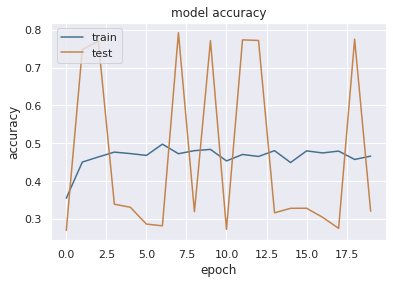

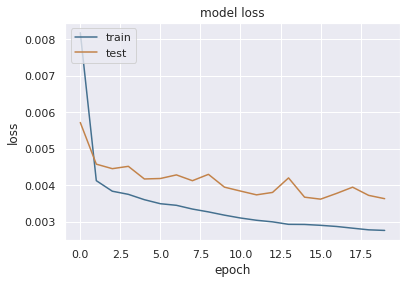

In [103]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Evaluation of forecast

In [104]:
# inverse differenced forecast
def inverse_difference(actual, forecast, period):
  for i in range(len(forecast)):
    forecast[i]= forecast[i] + actual[-(len(forecast)+period-i)]
  return forecast

# inverse data transform on forecasts, adapted for seasonal differencing
# and multiple series
def inverse_transform_all(actual, forecasts, scaler, period):
  inverted = list()
  for i in range(len(forecasts)):
    # create array from forecast
    forecast = array(forecasts[i])
    act = array(actual[i])
    forecast = forecast.reshape(1, len(forecast))
    # invert scaling
    inv_scale = scaler.inverse_transform(forecast)
    inv_scale = inv_scale[0, :]
    # invert differencing 

    #index = len(series) - n_test + i - period
    inv_diff = inv_scale 
    # store
    inverted.append(inv_diff)
  return inverted

# evaluate the forecast with MAE
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
  for i in range(n_seq):
    actual = [row[i] for row in test]
    predicted = [forecast[i] for forecast in forecasts]
    mae = mean_absolute_error(actual, predicted)
    print('t+%d MAE: %f' % ((i+1), mae))



In [105]:
#LSTM evaluation

# inverse transform forecasts
LSTM_forecasts = inverse_transform_all(test_actual, forecasts, scaler, period)
test_actual_output = [list(row[n_steps:]) for row in test_actual]

# evaluate forecasts
evaluate_forecasts(test_actual_output, LSTM_forecasts, n_steps, n_output) 

t+1 MAE: 462.593991
t+2 MAE: 511.946766
t+3 MAE: 811.647765


# Baselines

Making SARIMA forecasts and using forward filling

In [106]:
#Preparing data for SARIMA model

#Dates to use for input
dates_short_2=dfA_short.index

#Dates to use for exogenous variable shifted 3 months
dates_short_2_shifted = dates_short_2.shift(-3, freq='MS')

#Getting the article numbers used for LSTM models
cols = dfA_short.columns

#Price as exogenous values
dfP_short = dfTestP.iloc[12:]
dfP_short.index = dfP_short['År_Måned']

#Price as exogenous values
dfT_short = dfTestT.iloc[9:-3]
dfT_short.index = dfT_short['År_Måned']

S_X = {}
S_Y = {}
S_XX = {}
S_XY = {}
S_names = []

for col in cols:
  for i in range(n_test):
    name = col*1000+i+1
    S_names.append(name)
    S_X[name] = dfA_short[col][:(len(dates_short_2)-n_test-n_output+i+1)]
    S_Y[name] = dfA_short[col][(len(dates_short_2)-n_test-n_output+i+1):(len(dates_short_2)-n_test-n_output+i+3+1)]
    #Price as exogenous value
    if exog=='Price':
      S_XX[name] = dfP_short[col][:(len(dates_short_2)-n_test-n_output+i+1)]
      S_XY[name] = dfP_short[col][(len(dates_short_2)-n_test-n_output+i+1):(len(dates_short_2)-n_test-n_output+i+3+1)]

    #Sales of top ranked article as exogenous value
    if exog=='Top':
      S_XX[name] = dfT_short[col][:(len(dates_short_2_shifted)-n_test-n_output+i+1)]
      S_XY[name] = dfT_short[col][(len(dates_short_2_shifted)-n_test-n_output+i+1):(len(dates_short_2_shifted)-n_test-n_output+i+3+1)]

      #Shifting dates back to match SARIMA model    
      S_XX[name] = S_XX[name].shift(3, freq='MS')
      S_XY[name] = S_XY[name].shift(3, freq='MS')

#Ignoring convergence warnings to avoid printing too many lines
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)


def baselines(load=True):
  if load==True:
    forward_filling = np.load(ff_file)
    s_forecasts = np.load(s_file)
  else:
    s_forecasts = []
    forward_filling = []
    arima = pm.ARIMA(order=(1, 1, 0), seasonal_order=(1, 0, 1, 12))

    for j in range(len(cols)):
      print(j)

      try:
        arima.fit(S_X[S_names[0+j*n_test]], X = array(S_XX[S_names[j*n_test]]).reshape(-1, 1)) #
        pred = arima.predict(n_periods=3, X=array(S_XY[S_names[j*n_test]]).reshape(-1,1)) #
        s_forecasts.append(pred)
        forward_filling.append([S_X[S_names[0+j*n_test]][-1],
                                S_X[S_names[0+j*n_test]][-1],
                                S_X[S_names[0+j*n_test]][-1]])

        for i in range(23):
          try: 
            arima.update(S_X[S_names[i+1+j*n_test]][-1], X=array(S_XX[S_names[i+1+j*n_test]][-1]).reshape(-1,1)) #
            pred = arima.predict(n_periods=3,X=array(S_XY[S_names[i+1+j*n_test]]).reshape(-1,1)) #
            s_forecasts.append(pred)
          except:
            print(j,i)   
            s_forecasts.append([S_X[S_names[0+j*n_test]][-1],
                                S_X[S_names[0+j*n_test]][-1],
                                S_X[S_names[0+j*n_test]][-1]])
            
          forward_filling.append([S_X[S_names[i+1+j*n_test]][-1],
                                S_X[S_names[i+1+j*n_test]][-1],
                                S_X[S_names[i+1+j*n_test]][-1]])
          
      except:
        for i in range(24):
          print('forward filling instead')
          s_forecasts.append([S_X[S_names[i+j*n_test]][-1],
                                S_X[S_names[i+j*n_test]][-1],
                                S_X[S_names[i+j*n_test]][-1]])
          forward_filling.append([S_X[S_names[i+j*n_test]][-1],
                                S_X[S_names[i+j*n_test]][-1],
                                S_X[S_names[i+j*n_test]][-1]])


    np.save('sarimax_forecasts.npy',s_forecasts)
    np.save('forward_filling.npy',forward_filling)
  return s_forecasts, forward_filling


if sarima_status=='run': 

  s_forecasts, forward_filling = baselines(load=sarima_load) 

  #The forward filling and SARIMA models are run on samples that are not to be 
  #evaluted, as these are in the wrong price group. These have to be removed after
  #forecasting rather than before as for LSTM, as the used update method depends 
  #on continuous samples.

  test_names=[]
  for i in range(len(test)):
    name = int(test[i][-2]*1000+(test[i][-1]-125))
    test_names.append(name)

  #Constructing mask for samples to evaluate
  name_mask = np.in1d(S_names, test_names)

  #Changes array of array into 2d array
  s_forecasts = np.stack(s_forecasts)
  forward_filling = np.stack(forward_filling)

  #Uses mask on forecasts, only correct samples are left
  s_forecasts = s_forecasts[name_mask] 
  forward_filling = forward_filling[name_mask] 

  #SARIMA evaluation
  test_actual_output = [list(row[n_steps:]) for row in test_actual]
  print(evaluate_forecasts(test_actual_output, s_forecasts, n_steps, n_output))

  #Forward filling evaluation
  print(evaluate_forecasts(test_actual_output, forward_filling, n_steps, n_output))



t+1 MAE: 5487.419826
t+2 MAE: 5486.204810
t+3 MAE: 5489.498498
None
t+1 MAE: 5489.766706
t+2 MAE: 5488.120047
t+3 MAE: 5489.390893
None


# Ranking

Choose which model you want to analyze below. Press ctrl+F10 after changing variable to run the cells from here on down. 

In [107]:
#LSTM_forecasts for LSTM, s_forecasts for SARIMA or forward_filling for 
#persistence forecast
chosen_forecast=LSTM_forecasts 

#Adding forecasts to test samples, to keep track of dates and article numbers 
forecast_list = [list(row) for row in chosen_forecast]
test_list = [list(row) for row in test]
forecast_samples = [a + b for a, b in zip(test_list, forecast_list)]

#Dataframe of samples with forecast
dfForecast = pd.DataFrame(forecast_samples)
dfForecast.drop(dfForecast.iloc[:, 0:(n_input+n_output)], inplace = True, axis = 1)
dfForecast.columns = ['Artikkelnr', 'År_Måned', 'F1', 'F2', 'F3']
dfForecast['Artikkelnr'] = dfForecast['Artikkelnr'].astype(int)
dfForecast['År_Måned'] = dfForecast['År_Måned'].apply(lambda x: date_map[x])
test_dates = list(dict.fromkeys(dfForecast['År_Måned']))

#Making a dataframe with information about current date, and the next three months
#Using date and article number to merge forecasts with relevant columns, then
# shifting the columns by one month and adding them again
def shift_date(df,months):
  df = df.reset_index()
  df['År_Måned'] = df['År_Måned'].apply(lambda x: inv_date_map[x])
  df['År_Måned']=df['År_Måned']-months
  df = df[(df['År_Måned']>0)&(df['År_Måned']<153)]
  df['År_Måned'] = df['År_Måned'].apply(lambda x: date_map[x])
  df = df.set_index(['Artikkelnr', 'År_Måned']).sort_index()
  return df

dfForecast = dfForecast.set_index(['Artikkelnr', 'År_Måned']).sort_index()
dfInfo = dfRed2[['Segmentpris', 'Netto Salg', 'Rangering']]
dfForecast = dfForecast.merge(dfInfo, 'left', left_index=True, right_index=True)
dfInfo = shift_date(dfInfo,1)
dfForecast = dfForecast.merge(dfInfo, 'left', left_index=True, right_index=True)
dfInfo = shift_date(dfInfo,1)
dfForecast = dfForecast.merge(dfInfo, 'left', left_index=True, right_index=True)
dfInfo = shift_date(dfInfo,1)
dfForecast = dfForecast.merge(dfInfo, 'left', left_index=True, right_index=True)
rlInfo = dfRed2[['Styringstall']]
dfForecast = dfForecast.merge(rlInfo, 'left', left_index=True, right_index=True)
dfForecast.columns = [ 'F1', 'F2', 'F3', 'P0', 'S0', 'R0', 'P1', 'S1', 'R1', 'P2', 'S2', 'R2', 'P3', 'S3', 'R3', 'RL']
dfForecast = dfForecast.reindex(sorted(dfForecast.columns), axis=1)
dfForecast = dfForecast.reset_index()


#Column that shows 1 if in basisutvalget(or below set limit) and 0 otherwise
dfForecast['B0'] = np.where(dfForecast['R0']<=dfForecast['RL'], 1, 0)
dfForecast['B1'] = np.where(dfForecast['R1']<=dfForecast['RL'], 1, 0)
dfForecast['B2'] = np.where(dfForecast['R2']<=dfForecast['RL'], 1, 0)
dfForecast['B3'] = np.where(dfForecast['R3']<=dfForecast['RL'], 1, 0)

#Column that shows 1 if product enters basisutvalget, 0 if it stays where it is
#and -1 if it leaves basisutvalget
dfForecast['C1'] = dfForecast['B1'] - dfForecast['B0'] 
dfForecast['C2'] = dfForecast['B2'] - dfForecast['B0'] 
dfForecast['C3'] = dfForecast['B3'] - dfForecast['B0']

#Takes in a series and returns ranking of values 
def ranking(x):
  return (x.rank(method='min', ascending=False))
  #return ss.rankdata(x)

#Ranks forecasts for each date for t+1, t+2 and t+3
dfForecast = dfForecast.assign(FR1=dfForecast.groupby(['År_Måned'])['F1'].apply(lambda x: ranking(x)))
dfForecast = dfForecast.assign(FR2=dfForecast.groupby(['År_Måned'])['F2'].apply(lambda x: ranking(x)))
dfForecast = dfForecast.assign(FR3=dfForecast.groupby(['År_Måned'])['F3'].apply(lambda x: ranking(x)))

#Column that shows 1 if forecasted to be in basisutvalget(or below set limit) 
#and 0 otherwise
dfForecast['FB1'] = np.where(dfForecast['FR1']<=dfForecast['RL'], 1, 0)
dfForecast['FB2'] = np.where(dfForecast['FR2']<=dfForecast['RL'], 1, 0)
dfForecast['FB3'] = np.where(dfForecast['FR3']<=dfForecast['RL'], 1, 0)

#Column that shows 1 if product enters basisutvalget, 0 if it stays where it is
#and -1 if it leaves basisutvalget, based on forecasts
dfForecast['FC1'] = dfForecast['FB1'] - dfForecast['B0'] 
dfForecast['FC2'] = dfForecast['FB2'] - dfForecast['B0'] 
dfForecast['FC3'] = dfForecast['FB3'] - dfForecast['B0']


In [108]:
#Evaluating forecasts for t+1, t+2 and t+3

#Initializing lists for evaluation
c1, fc1, c2, fc2, c3, fc3 = [],[],[],[],[],[]
r0, r1, fr1, r2, fr2, r3, fr3 = [],[],[],[],[],[],[]
dr1, dfr1, dr2, dfr2, dr3, dfr3 = [],[],[],[],[],[]

#Ranking limit which adapts to date 
r_limit = styring(dfPG[eval_PG[0]])
r_limit['År_Måned'] = pd.to_datetime(r_limit['År_Måned'])
r_limit = r_limit.set_index(['År_Måned'])

for date in test_dates:
  #Ranking limit
  if status=='full':
    rl = int(r_limit.loc[date])
    #Evaluating clases of products outside of basisutvalget as well
    rlc = round(max(styring(dfPG[eval_PG[0]])['Styringstall'])*1.2)
  #Using set ranking limit when running tests  
  else:
    rl = 10
    rlc = 12
  

  #Classes used for precision and recall
  c1 += list(dfForecast[dfForecast['År_Måned']==date].sort_values(['R1'])['C1'][:rlc])
  fc1 += list(dfForecast[dfForecast['År_Måned']==date].sort_values(['R1'])['FC1'][:rlc])
  c2 += list(dfForecast[dfForecast['År_Måned']==date].sort_values(['R2'])['C2'][:rlc])
  fc2 += list(dfForecast[dfForecast['År_Måned']==date].sort_values(['R2'])['FC2'][:rlc])
  c3 += list(dfForecast[dfForecast['År_Måned']==date].sort_values(['R3'])['C3'][:rlc])
  fc3 += list(dfForecast[dfForecast['År_Måned']==date].sort_values(['R3'])['FC3'][:rlc])

  #Rankings used for mean shift, ordered by current date's correct ranking
  r0 += list(dfForecast[dfForecast['År_Måned']==date].sort_values(['R0'])['R0'][:rl])
  r1 += list(dfForecast[dfForecast['År_Måned']==date].sort_values(['R0'])['R1'][:rl])
  fr1 += list(dfForecast[dfForecast['År_Måned']==date].sort_values(['R0'])['FR1'][:rl])
  r2 += list(dfForecast[dfForecast['År_Måned']==date].sort_values(['R0'])['R2'][:rl])
  fr2 += list(dfForecast[dfForecast['År_Måned']==date].sort_values(['R0'])['FR2'][:rl])
  r3 += list(dfForecast[dfForecast['År_Måned']==date].sort_values(['R0'])['R3'][:rl])
  fr3 += list(dfForecast[dfForecast['År_Måned']==date].sort_values(['R0'])['FR3'][:rl])

  #Rankings used for mean difference ordered by evaluated date's correct ranking
  dr1 += list(dfForecast[dfForecast['År_Måned']==date].sort_values(['R1'])['R1'][:rl])
  dfr1 += list(dfForecast[dfForecast['År_Måned']==date].sort_values(['R1'])['FR1'][:rl])
  dr2 += list(dfForecast[dfForecast['År_Måned']==date].sort_values(['R2'])['R2'][:rl])
  dfr2 += list(dfForecast[dfForecast['År_Måned']==date].sort_values(['R2'])['FR2'][:rl])
  dr3 += list(dfForecast[dfForecast['År_Måned']==date].sort_values(['R3'])['R3'][:rl])
  dfr3 += list(dfForecast[dfForecast['År_Måned']==date].sort_values(['R3'])['FR3'][:rl])



cm={}
cm[1] = confusion_matrix(c1, fc1, labels=[1, 0, -1])
cm[2] = confusion_matrix(c2, fc2, labels=[1, 0, -1])
cm[3] = confusion_matrix(c3, fc3, labels=[1, 0, -1])

#Calculating precision and recall

pre = {}
rec = {}

pre[1] = precision_score(c1,fc1,average=None)
rec[1] = recall_score(c1,fc1,average=None)
pre[2] = precision_score(c2,fc2,average=None)
rec[2] = recall_score(c2,fc2,average=None)
pre[3] = precision_score(c3,fc3,average=None)
rec[3] = recall_score(c3,fc3,average=None)

#Calculating mean shift

def mean_shift(ranks, f_ranks):
  if len(ranks)==len(f_ranks):
    difference = []
    zip_object = zip(ranks, f_ranks)
    for ranks, f_ranks in zip_object:
      difference.append(np.abs(f_ranks-ranks))
    difference= np.nan_to_num(difference)
    mean = np.mean(difference)
    return(mean)
  else:
    print('Wrong length of lists')

shift = {}
shift[4] = mean_shift(r0,r1)
shift[1] = mean_shift(r0,fr1)
shift[5] = mean_shift(r0,r2)/2
shift[2] = mean_shift(r0,fr2)/2
shift[6] = mean_shift(r0,r3)/3
shift[3] = mean_shift(r0,fr3)/3

#Calculating Spearmans rho
rho={}
rho[1],p = spearmanr(dr1,dfr1)
rho[2],p = spearmanr(dr2,dfr2)
rho[3],p = spearmanr(dr3,dfr3)

#Ranking score based on difference
def ranking_score(rank1, rank2, l):
  n=len(rank1)
  difference = []
  zip_object = zip(rank1, rank2)
  for ranks, f_ranks in zip_object:
    difference.append(np.abs(f_ranks-ranks))
  score = 1- sum([l if value >=l else value for value in difference])/(l*n)
  return score

score= {}
l=10
score[1]=ranking_score(dr1,dfr1,l)
score[2]=ranking_score(dr2,dfr2,l)
score[3]=ranking_score(dr3,dfr3,l)

In [109]:
#Results for the chosen model 
#Model choice is decided with the chosen_forecast variable at the beginning of
#the Ranking section. 

for i in range(1,4):
  print('Forecast t+',i,':')
  print('Precision')
  print(pre[i])
  print('Recall')
  print(rec[i])
  print('Relative absolute shift')
  print(shift[i]/shift[i+3])
  print('Spearman\'s rho')
  print(rho[i])
  print('Score')
  print(score[i])
  print('')
evaluate_forecasts(test_actual_output, chosen_forecast, n_steps, n_output) 

Forecast t+ 1 :
Precision
[0.48387097 0.97797588 0.23333333]
Recall
[0.45454545 0.97951681 0.22580645]
Relative absolute shift
1.0244886975242196
Spearman's rho
0.9687678541114858
Score
0.7522758620689656

Forecast t+ 2 :
Precision
[0.60869565 0.96592119 0.34090909]
Recall
[0.47457627 0.97474476 0.3125    ]
Relative absolute shift
0.7881658642646373
Spearman's rho
0.9422804744196341
Score
0.6800689655172414

Forecast t+ 3 :
Precision
[0.59677419 0.9501895  0.27118644]
Recall
[0.45121951 0.96269885 0.25396825]
Relative absolute shift
0.7368055555555554
Spearman's rho
0.9057272950979064
Score
0.5844827586206897

t+1 MAE: 462.593991
t+2 MAE: 511.946766
t+3 MAE: 811.647765


In [110]:
#Results that can be copied directly into .csv file. Can fail when using 
#status = 'testing' as there are too few products to guarantee that a product 
#will leave or enter basisutvalget and precision and recall lack the indices we
#request

def find_mae(test, forecasts, n_lag, n_seq,i):
  actual = [row[i] for row in test]
  predicted = [forecast[i] for forecast in forecasts]
  mae = mean_absolute_error(actual, predicted)
  return mae

results =[find_mae(test_actual_output, chosen_forecast, n_steps, n_output,0),
          find_mae(test_actual_output, chosen_forecast, n_steps, n_output,1),
          find_mae(test_actual_output, chosen_forecast, n_steps, n_output,2),
          score[1],score[2],score[3],rho[1],rho[2],rho[3],shift[1]/shift[4],
          shift[2]/shift[5],shift[3]/shift[6], pre[1][0],pre[1][1],pre[1][2],
          pre[2][0],pre[2][1],pre[2][2],pre[3][0],pre[3][1],pre[3][2],rec[1][0],
          rec[1][1],rec[1][2],rec[2][0],rec[2][1],rec[2][2], rec[3][0],
          rec[3][1],rec[3][2]]

# Plotting

In [111]:
#Functions, dictionaries and lists neccessary for plotting
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(10, 6)})
sns.set_palette("tab10", n_colors=10, desat=0.5, color_codes=True)
color=['b','r','g','y','m']

#Returns only ranking limit and date of dataframe
def styring(df):
  styring = df[df['Rangering']==1]
  return styring[['År_Måned', 'Styringstall']]

#Returns only the ranking and date of given article in dataframe
def rangering(df, article):
  ranks = df[df['Artikkelnr']==article]
  return ranks[['År_Måned', 'Rangering']]

#Returns only the price and date (as index) of given article in dataframe
def pricing(df, article):
  price = df[df['Artikkelnr']==article]
  price.set_index(pd.DatetimeIndex(price['År_Måned']), inplace=True)
  return price['Segmentpris']

#Identifying the top 5 wines jan 2007
high100 = dfPG[100][dfPG[100]['Rangering']<=5]
high100start = high100[high100['År_Måned']=='2007-01-01']
highArticles100start=high100start['Artikkelnr'].tolist()
highArticles100start=list(dict.fromkeys(highArticles100start))

#Identifying the 5 lower ranked wines jan 2007
low100 = dfPG[100][(dfPG[100]['Rangering']>50) & (dfPG[100]['Rangering']<=55)]
low100start = low100[low100['År_Måned']=='2007-01-01']
lowArticles100start=low100start['Artikkelnr'].tolist()
lowArticles100start=list(dict.fromkeys(highArticles100start))

#Identifying the top 5 wines sep 2019
high100end = high100[high100['År_Måned']=='2019-09-01']
highArticles100end=high100end['Artikkelnr'].tolist()
highArticles100end=list(dict.fromkeys(highArticles100end))

#Making a dictionary of the top 50 wines of each price group
dfTop50={}
for price in pg:
  dfTop50[price] = dfPG[price][dfPG[price]['Rangering']<=50]

#Making dictionary of lists of top 50 ranked wines jan 2007 for each price group
Top50Articles={}
for price in pg:
  a = dfTop50[price][dfTop50[price]['År_Måned']=='2007-01-01']
  a = a['Artikkelnr'].tolist()
  a = list(dict.fromkeys(a))
  Top50Articles[price] = a

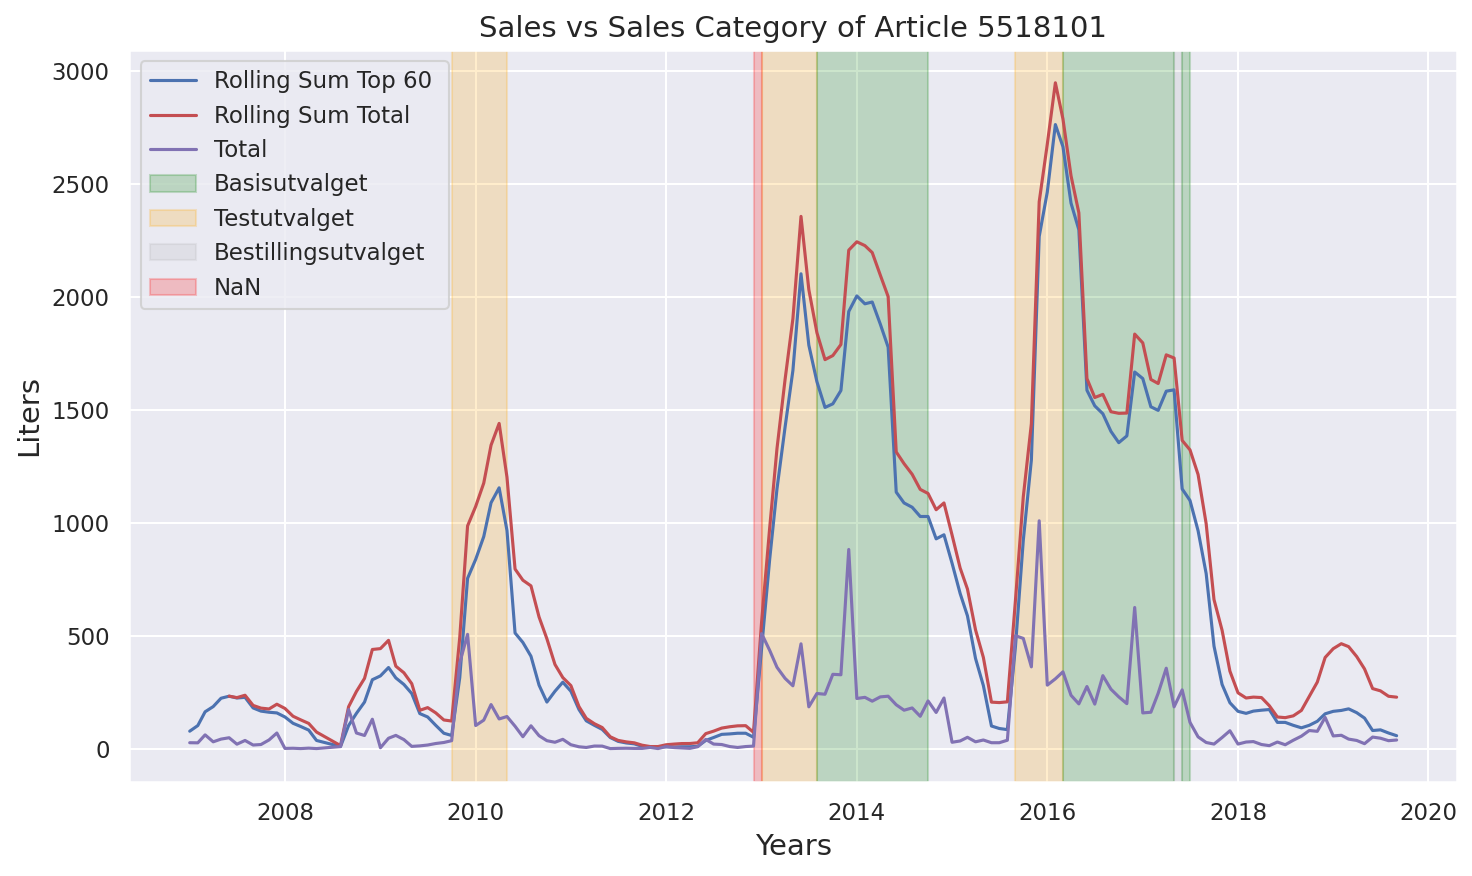

In [112]:
plt.figure(dpi=150)
plt.title('Sales vs Sales Category of Article 5518101',size=14)
plt.xlabel('Years',size=14)
plt.ylabel('Liters',size=14)
for i in range(1):
  plt.plot(dfRed2.loc[5518101]['Netto Salg'], color=color[i], label='Rolling Sum Top 60 ')
  plt.plot(dfRed2.loc[5518101]['Liter'].rolling(6).sum(), color=color[1], label='Rolling Sum Total')
  plt.plot(dfRed2.loc[5518101]['Liter'], color=color[4], label='Total')
  #plt.plot(netto[i], color=color[i], ls='--')
plt.axvspan(dates[33], dates[40], color="orange", alpha=0.2)


plt.axvspan(dates[72], dates[79], color="orange", alpha=0.2)
plt.axvspan(dates[79], dates[93], color="green", alpha=0.2, label='Basisutvalget')
plt.axvspan(dates[104], dates[110], color="orange", alpha=0.2, label='Testutvalget')
plt.axvspan(dates[110], dates[124], color="green", alpha=0.2)
plt.axvspan(dates[124], dates[125], color="grey", alpha=0.1, label='Bestillingsutvalget')
plt.axvspan(dates[125], dates[126], color="green", alpha=0.2)
plt.axvspan(dates[71], dates[72], color="red", alpha=0.2, label='NaN')
plt.legend()

plt.tight_layout()
plt.savefig("utvalg.png")

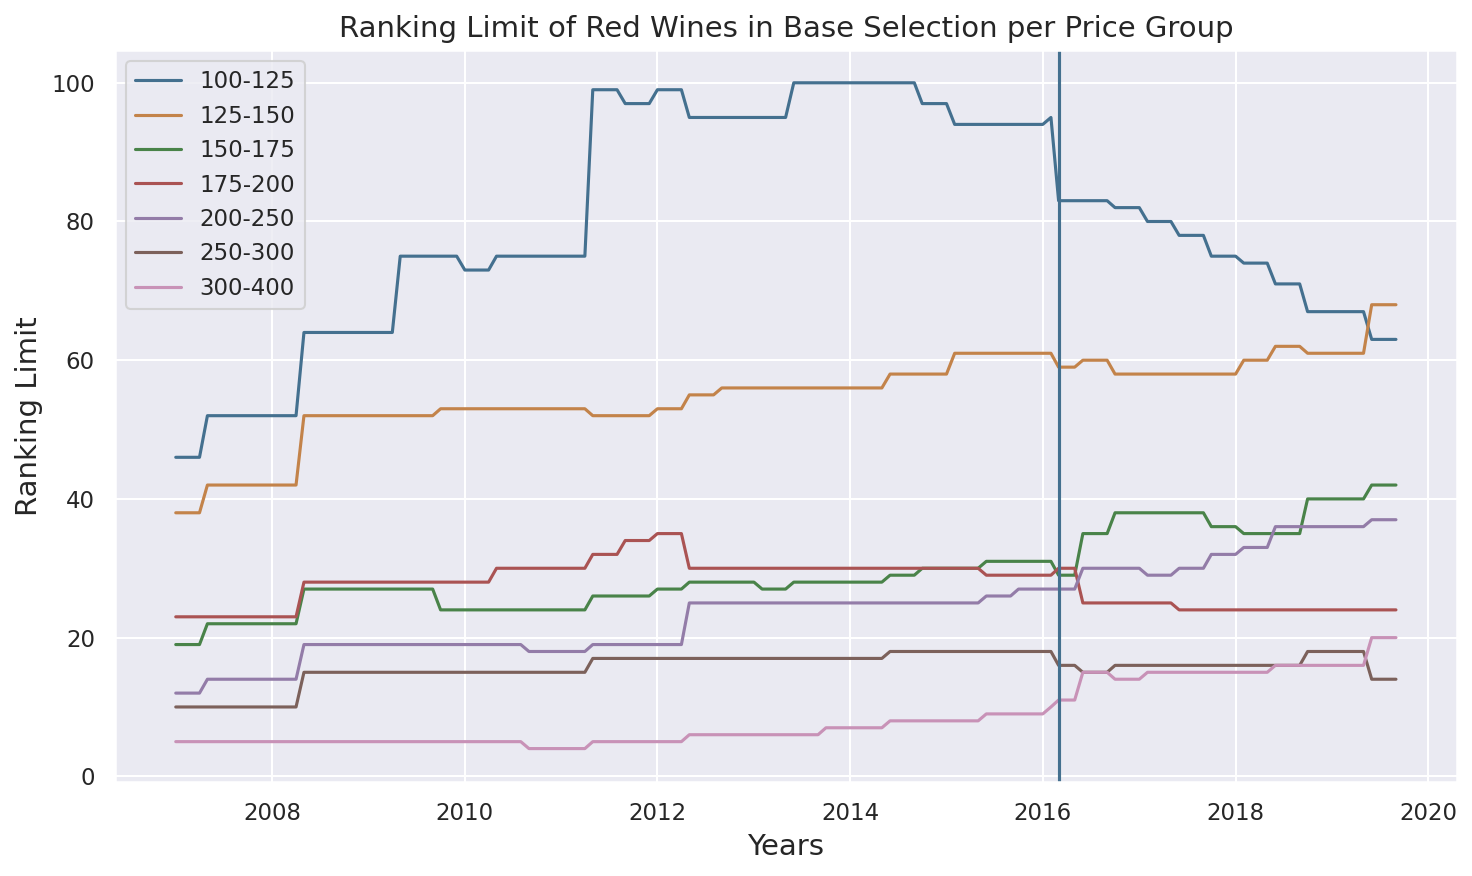

In [113]:
#Plotting the ranking limits of the different price groups

styringstall=np.zeros((7,153))

#dates=styring(dfPG[100])['År_Måned']

styringstall[0]=styring(dfPG[100])['Styringstall']
styringstall[1]=styring(dfPG[125])['Styringstall']
styringstall[2]=styring(dfPG[150])['Styringstall']
styringstall[3]=styring(dfPG[175])['Styringstall']
styringstall[4]=styring(dfPG[200])['Styringstall']
styringstall[5]=styring(dfPG[250])['Styringstall']
styringstall[6]=styring(dfPG[300])['Styringstall']

plt.figure(dpi=150)
plt.title('Ranking Limit of Red Wines in Base Selection per Price Group',size=14)
plt.xlabel('Years',size=14)
plt.ylabel('Ranking Limit',size=14)
for i in range(7):
  plt.plot(dates, styringstall[i],label=pricegroups[i])
plt.axvline(datetime(2016, 3, 1))
plt.legend()
plt.tight_layout()
plt.savefig("styringstall.png")

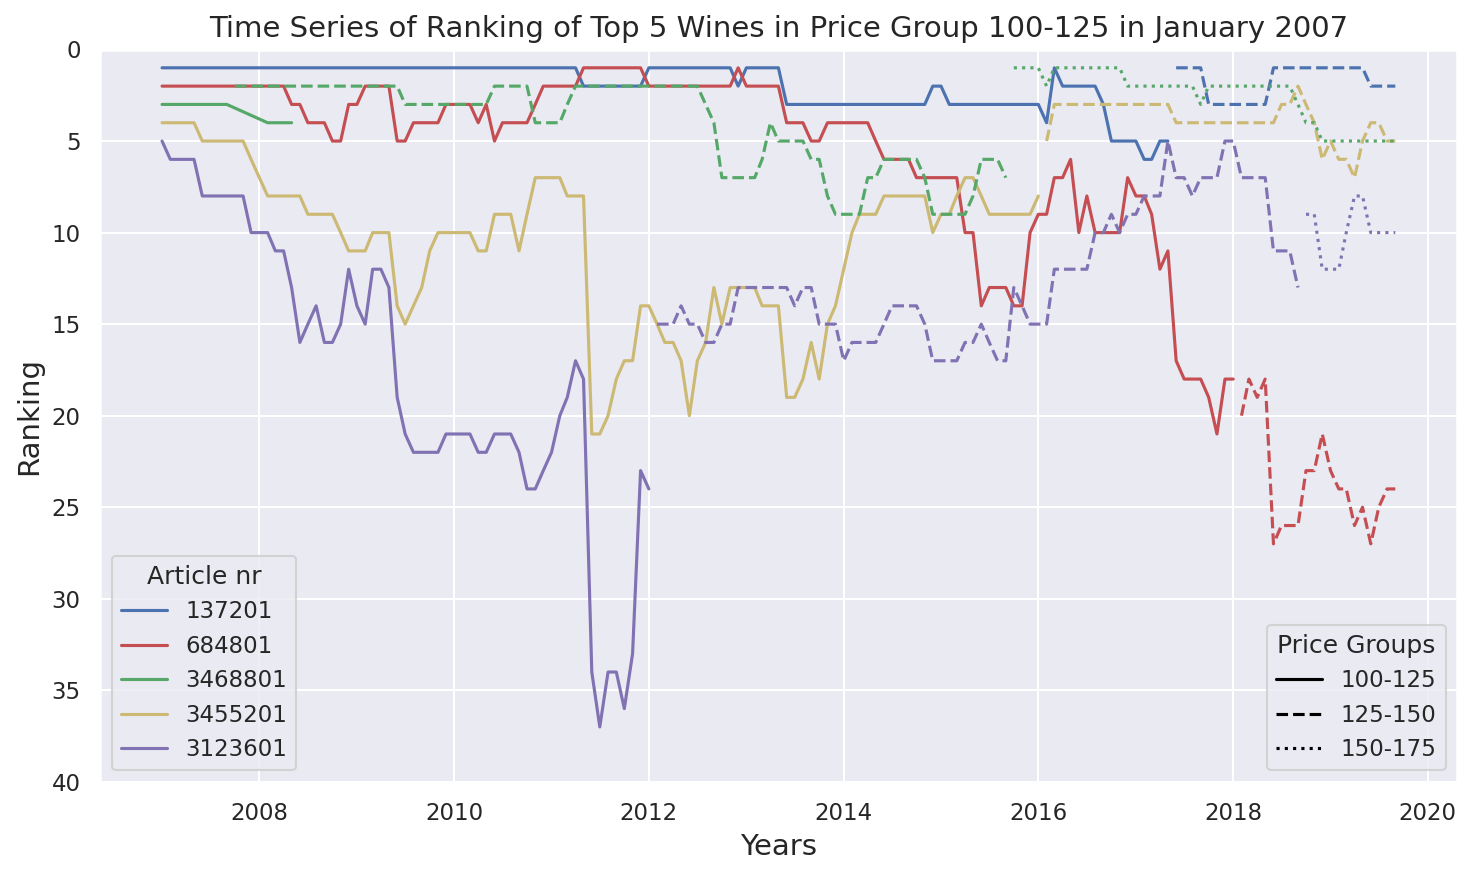

In [114]:
color=['b','r','g','y','m']

plt.figure(dpi=150)
plt.title('Time Series of Ranking of Top 5 Wines in Price Group 100-125 in January 2007',size=14)
plt.xlabel('Years',size=14)
plt.ylabel('Ranking',size=14)
for i in range(len(highArticles100start)):
  ts=rangering(dfPG[100], highArticles100start[i])
  plt.plot(ts['År_Måned'], ts['Rangering'],  color=color[i], label=highArticles100start[i])
for i in range(len(highArticles100start)):
  ts=rangering(dfPG[125], highArticles100start[i])
  plt.plot(ts['År_Måned'], ts['Rangering'], linestyle='--',  color=color[i])
for i in range(len(highArticles100start)):
  ts=rangering(dfPG[150], highArticles100start[i])
  plt.plot(ts['År_Måned'], ts['Rangering'], linestyle=':',  color=color[i])

plt.ylim(0,40)
plt.gca().invert_yaxis()
custom_lines = [Line2D([0], [0], color='black', linestyle='-'),
                Line2D([0], [0], color='black', linestyle='--'),
                Line2D([0], [0], color='black', linestyle=':')]


legend1 = plt.legend(custom_lines, ['100-125', '125-150', '150-175'], title='Price Groups', loc='lower right')
plt.legend(title='Article nr')
pyplot.gca().add_artist(legend1)

plt.tight_layout()
plt.savefig("first5_100.png")

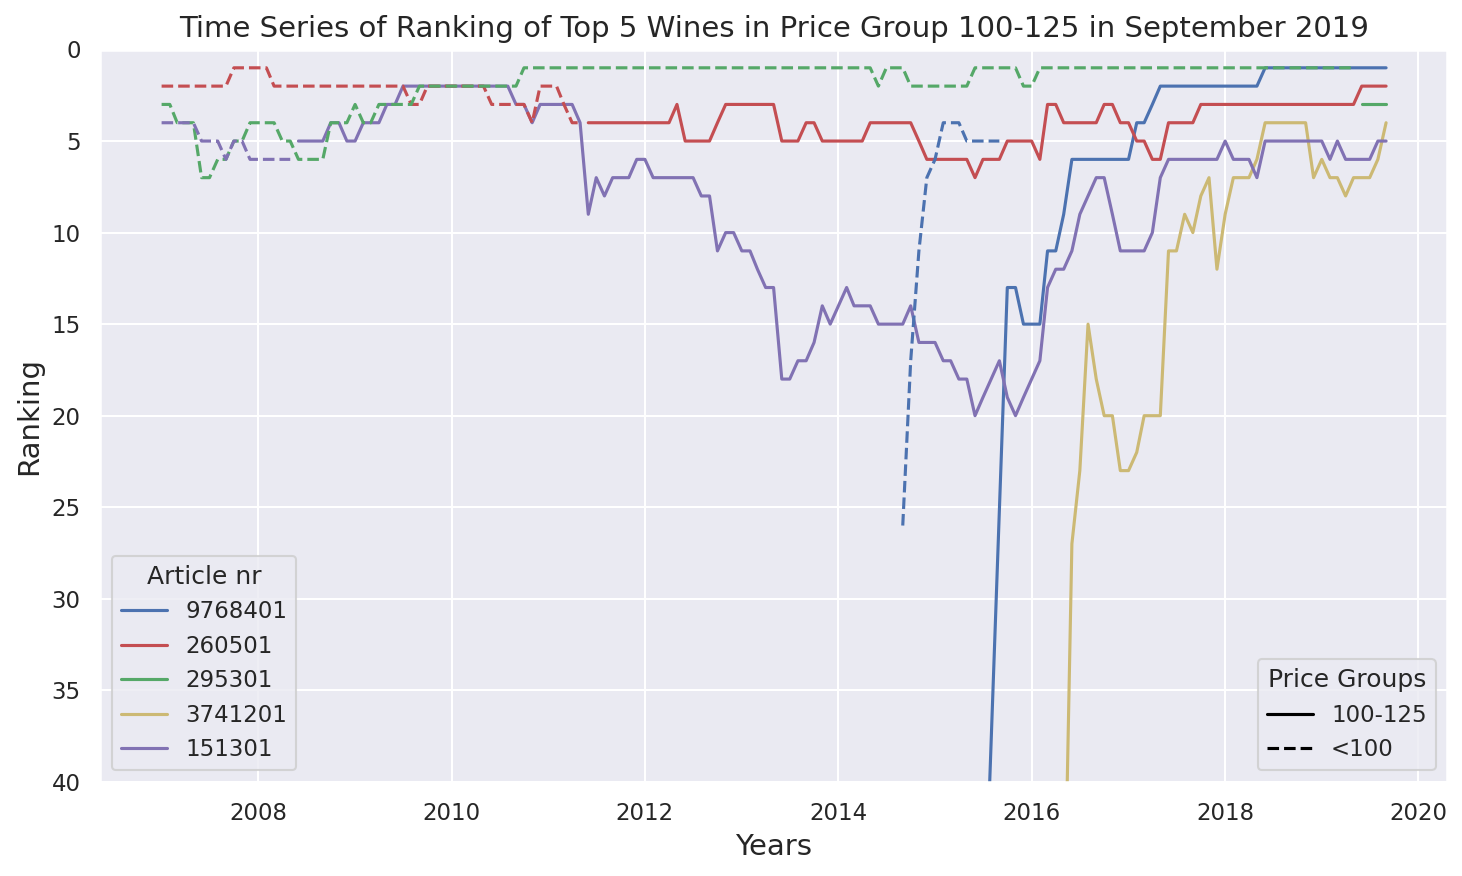

In [115]:
plt.figure(dpi=150)
plt.title('Time Series of Ranking of Top 5 Wines in Price Group 100-125 in September 2019',size=14)
plt.xlabel('Years',size=14)
plt.ylabel('Ranking',size=14)
for i in range(len(highArticles100end)):
  ts=rangering(dfPG[100], highArticles100end[i])
  plt.plot(ts['År_Måned'], ts['Rangering'],  color=color[i], label=highArticles100end[i])
for i in range(len(highArticles100end)):
  ts=rangering(dfPG[99], highArticles100end[i])
  plt.plot(ts['År_Måned'], ts['Rangering'], linestyle='--',  color=color[i])


plt.ylim(0,40)
plt.gca().invert_yaxis()
custom_lines = [Line2D([0], [0], color='black', linestyle='-'),
                Line2D([0], [0], color='black', linestyle='--'),
                Line2D([0], [0], color='black', linestyle=':')]


legend1 = plt.legend(custom_lines, ['100-125', '<100'], title='Price Groups', loc='lower right')
plt.legend(title='Article nr')
pyplot.gca().add_artist(legend1)

plt.tight_layout()
plt.savefig("last5_100.png")

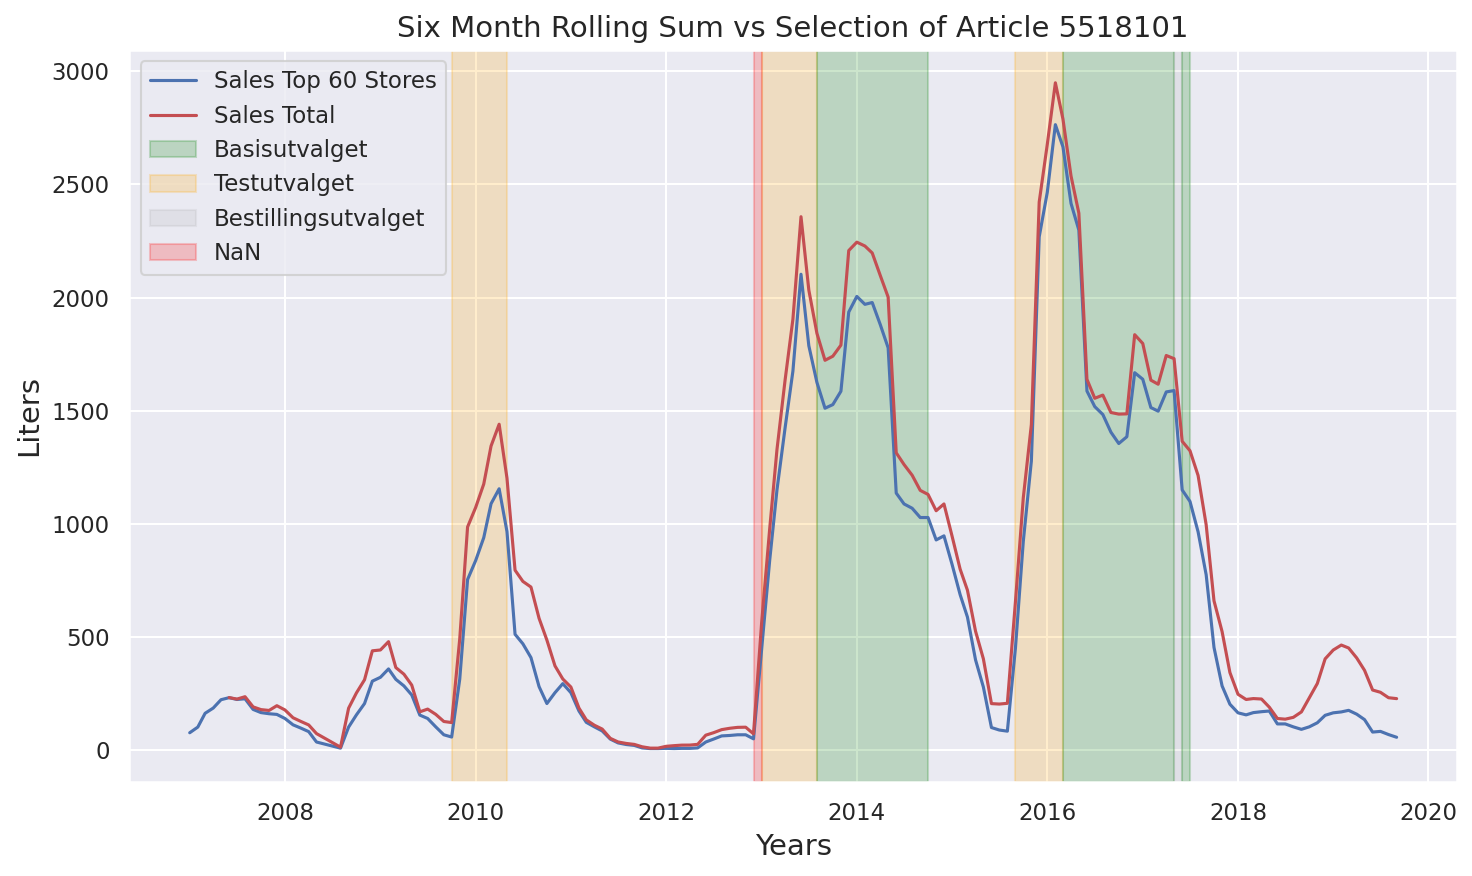

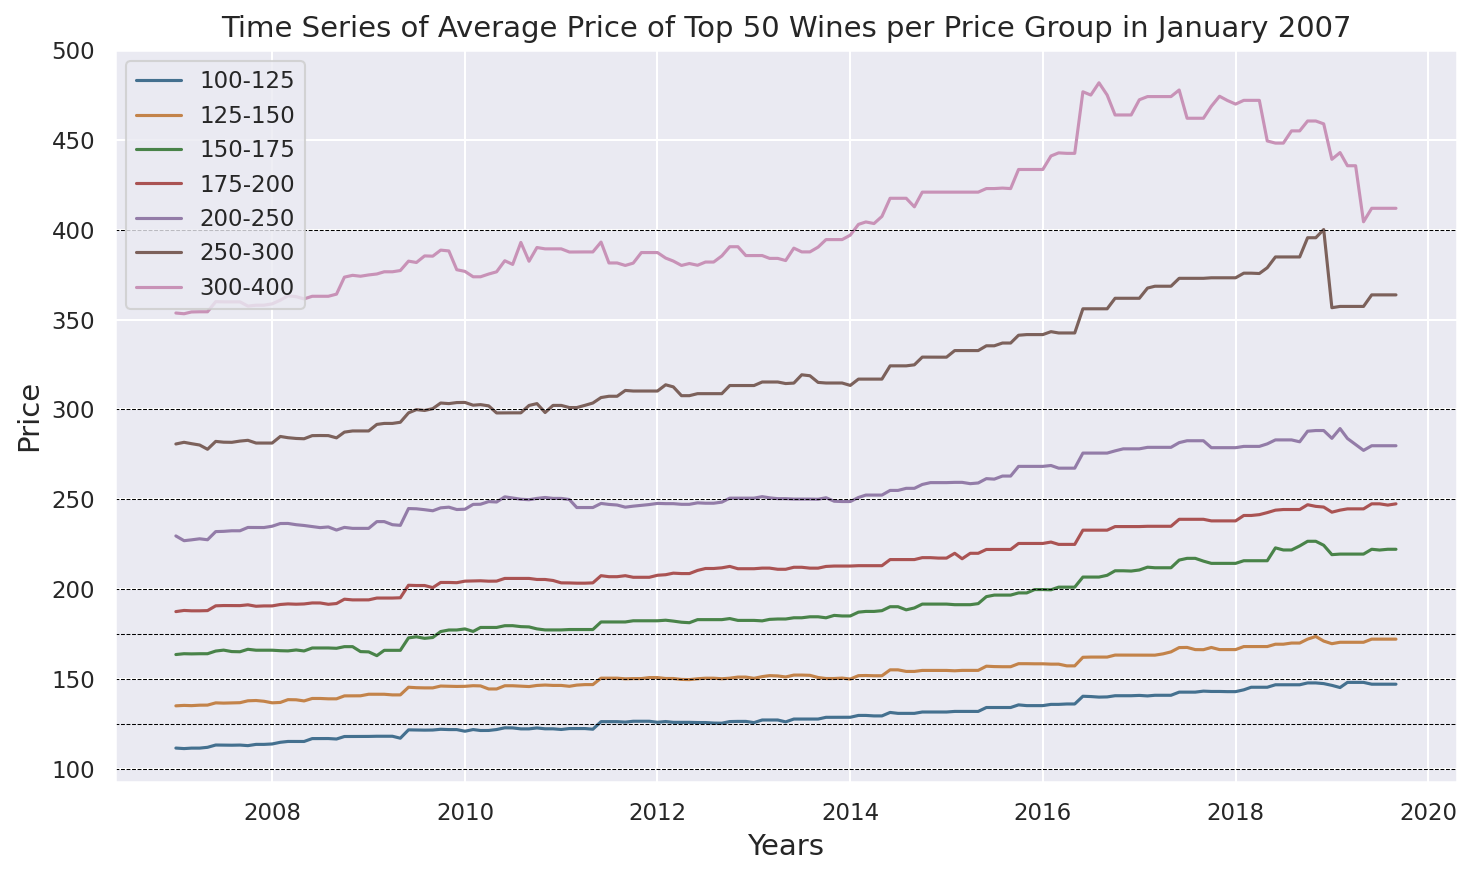

In [116]:
plt.figure(dpi=150)
plt.title('Six Month Rolling Sum vs Selection of Article 5518101',size=14)
plt.xlabel('Years',size=14)
plt.ylabel('Liters',size=14)
for i in range(1):
  plt.plot(dfRed2.loc[5518101]['Netto Salg'], color=color[i], label='Sales Top 60 Stores')
  plt.plot(dfRed2.loc[5518101]['Liter'].rolling(6).sum(), color=color[1], label='Sales Total')
  #plt.plot(netto[i], color=color[i], ls='--')
plt.axvspan(dates[33], dates[40], color="orange", alpha=0.2)


plt.axvspan(dates[72], dates[79], color="orange", alpha=0.2)
plt.axvspan(dates[79], dates[93], color="green", alpha=0.2, label='Basisutvalget')
plt.axvspan(dates[104], dates[110], color="orange", alpha=0.2, label='Testutvalget')
plt.axvspan(dates[110], dates[124], color="green", alpha=0.2)
plt.axvspan(dates[124], dates[125], color="grey", alpha=0.1, label='Bestillingsutvalget')
plt.axvspan(dates[125], dates[126], color="green", alpha=0.2)
plt.axvspan(dates[71], dates[72], color="red", alpha=0.2, label='NaN')
plt.legend()

plt.tight_layout()
plt.savefig("utvalg.png")#Finding median price of the top 50 articles for the different price groups as 
#they evolve over time

avgPrices={}

#Looping over price groups
for pricegroup in pg:

  #Setting up dataframe with random article
  dfPrices=pricing(dfRed,755501)

  #Looping over articles 
  for article in Top50Articles[pricegroup]:
    price = pricing(dfRed, article)
    dfPrices = pd.concat([dfPrices, price], axis=1)

  #Naming columns to remove initial article
  dfPrices.columns = [755501]+ Top50Articles[pricegroup]
  dfPrices.pop(755501)

  avgPrices[pricegroup] = dfPrices.mean(axis=1)


plt.figure(dpi=150)
plt.title('Time Series of Average Price of Top 50 Wines per Price Group in January 2007',size=14)
plt.xlabel('Years',size=14)
plt.ylabel('Price',size=14)
for i in range(7):
  plt.plot(dates, avgPrices[pg[i+1]],label=pricegroups[i])
plt.axhline(100, ls='--', lw=0.5, color='black')
plt.axhline(125, ls='--', lw=0.5, color='black')
plt.axhline(150, ls='--', lw=0.5, color='black')
plt.axhline(175, ls='--', lw=0.5, color='black')
plt.axhline(200, ls='--', lw=0.5, color='black')
plt.axhline(250, ls='--', lw=0.5, color='black')
plt.axhline(300, ls='--', lw=0.5, color='black')
plt.axhline(400, ls='--', lw=0.5, color='black')
plt.legend()
plt.tight_layout()
plt.savefig("priceEvolution.png")

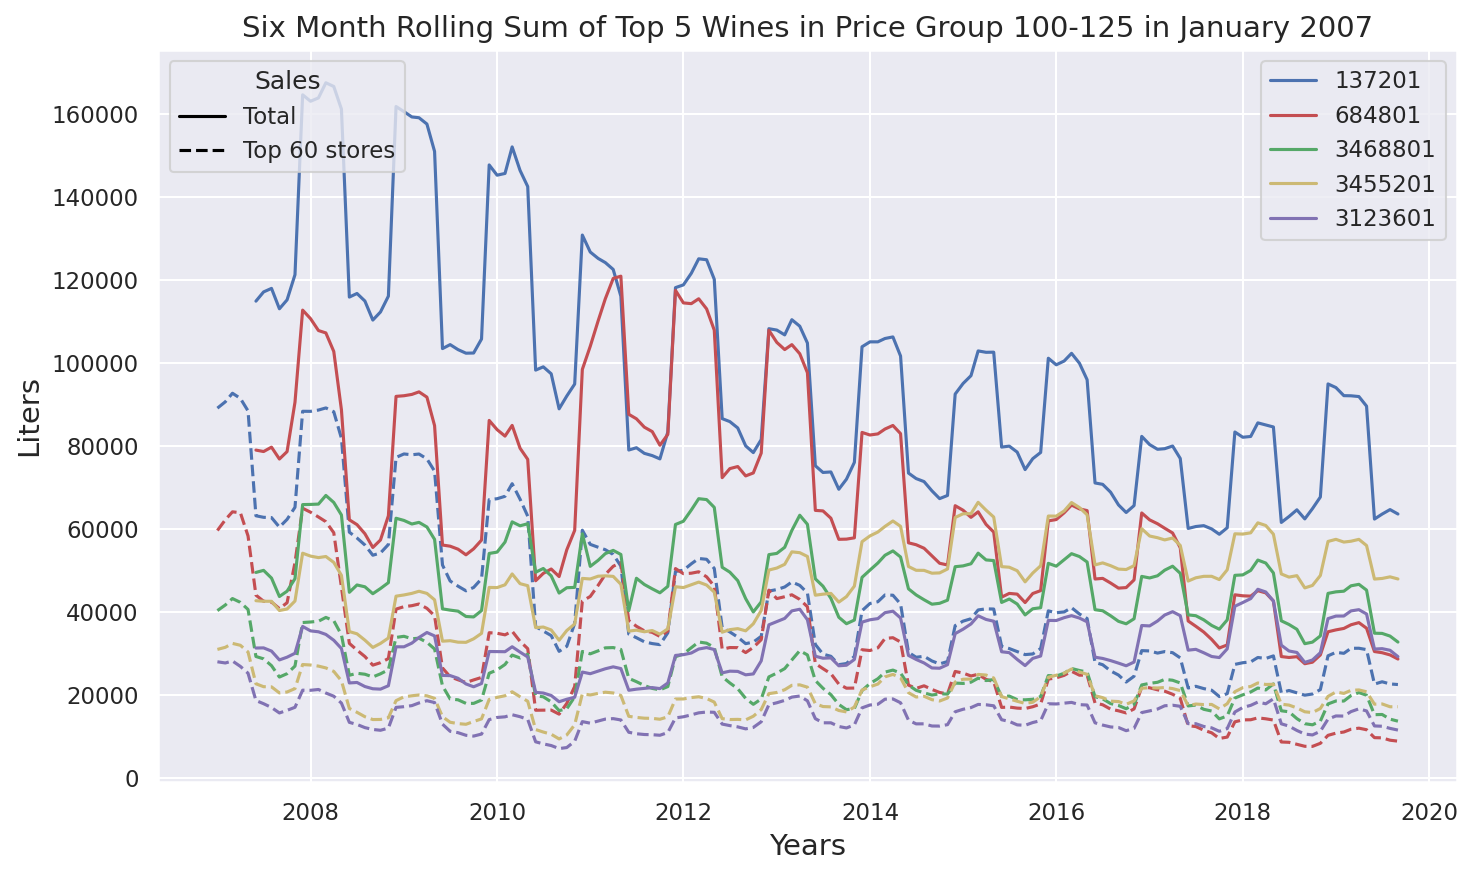

In [117]:
liter = np.zeros((5,len(dates)))
netto = np.zeros((5,len(dates)))
for i in range(len(highArticles100start)):
  for j in range(len(dates)):
    liter[i,j]=dfRed2.loc[lowArticles100start[i],dates[j]]['Liter']#!!!!!!!!!!!!!!!!
    netto[i,j]=dfRed2.loc[lowArticles100start[i],dates[j]]['Netto Salg']#!!!!!!!!!!!!

litersAgg = pd.DataFrame(np.transpose(liter)).rolling(6).sum()
netto = pd.DataFrame(np.transpose(netto))

litersAgg.index = dates
netto.index = dates

plt.figure(dpi=150)
plt.title('Six Month Rolling Sum of Top 5 Wines in Price Group 100-125 in January 2007',size=14)
plt.xlabel('Years',size=14)
plt.ylabel('Liters',size=14)
for i in range(len(highArticles100start)):
  plt.plot(litersAgg[i], color=color[i], label=highArticles100start[i])
  plt.plot(netto[i], color=color[i], ls='--')
plt.legend()
custom_lines = [Line2D([0], [0], color='black', linestyle='-'),
                Line2D([0], [0], color='black', linestyle='--')]


legend1 = plt.legend(custom_lines, ['Total', 'Top 60 stores'], title='Sales', loc='upper left')
plt.legend()
pyplot.gca().add_artist(legend1)

plt.tight_layout()
plt.savefig("nettoVStotal.png")

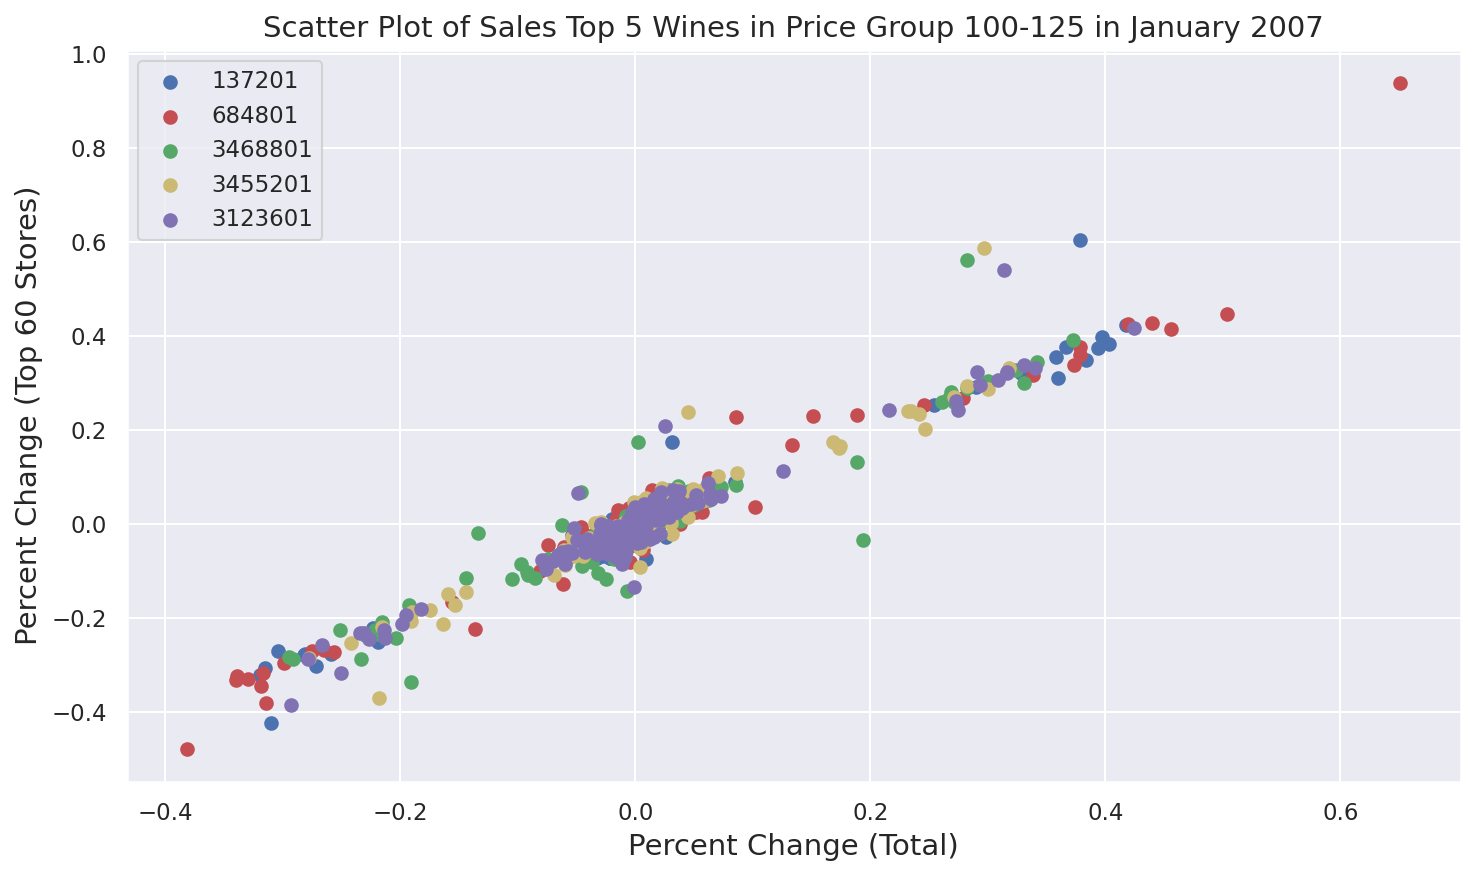

In [118]:
liters_chg = pd.DataFrame()
netto_chg = pd.DataFrame()

for i in range(len(highArticles100start)):
  liters_chg[i] = litersAgg[i].pct_change()
  netto_chg[i] = netto[i].pct_change()


plt.figure(dpi=150)
plt.title('Scatter Plot of Sales Top 5 Wines in Price Group 100-125 in January 2007',size=14)
plt.xlabel('Percent Change (Total)',size=14)
plt.ylabel('Percent Change (Top 60 Stores)',size=14)
for i in range(5):
  plt.scatter(liters_chg[i], netto_chg[i], color=color[i], label=highArticles100start[i])
plt.legend()
plt.tight_layout()
plt.savefig("scatterplot.png")